## Schwarzschild orbit-superposition modelling

This approach for constructing equilibrium models was introduced by [Martin Schwarzschild in 1979](http://adsabs.harvard.edu/abs/1979ApJ...232..236S) (after his retirement!), as the first practical demonstration that triaxial equilibrium galaxy models may exist – at the time, it was not at all obvious!

Originally, the method was purely a theorist's tool, but soon it was extended to take into account observational constraints and became one of standard tools in dynamical modelling (inferring the mass distribution from kinematic data). At the same time, its theoretical applications include the construction of initial conditions for $N$-body simulations. In both theoretical and observational flavours, its advantages are the ability to handle complicated geometry of the model (axisymmetric, triaxial and even a rotating bar) and a very flexible representation of the distribution function – the latter can also be a drawback, in the sense that the resulting models may have unphysically rapid variations of the DF across the phase space. To mitigate this situation, some regularisation is needed, as with any non-parametric method.

In this tutorial, we first discuss the fundamental concepts of the orbit-superposition method and the particular features of its implementation in `Agama` – essentially, the "theoretical" flavour of the method. Observational applications will be considered in the second part of this tutorial. Since the method works with orbits, it is essential to first complete the `tutorial_potential_orbits` notebook.

### Outline

The model is composed of building blocks – individual orbits. Each orbit is a point (delta function) in the integrals of motion space, and its weight represents the density of stars in the vicinity of this point, thus the distribution function of the entire model is approximated by a weighted superposition of delta functions. Of course, to compute orbits, we need the gravitational potential and an array of initial conditions for the orbit library – it can be generated in different ways, what is important is that it covers the entire space of integrals of motion reasonably well. For the model to be in equilibrium, we need to ensure that the density generated by the weighted superposition of orbits matches the gravitational potential via the Poisson equation. And when fitting the model to observations, we also need to record the contribution of orbits to the kinematic maps and assign the orbit weights in such a way as to maximize the match between the observed kinematics and the weighted sum of each orbit's contribution.

So the ingredients in the model are the following:

- Gravitational potential of the entire system $\Phi_\text{total}$.
- Initial conditions for the orbit library (a 2d array of $N_\text{orbits}$ 6d phase-space points).
- Orbits computed from these initial conditions.
- Data stored during the orbit integration: contribution of each orbit to the density profile and to kinematic maps: $K$ matrices $\mathsf{D}^{(k)}$ of shape $N_\text{orbits} \times N_\text{constraints}^{(k)}$, where $k=1..K$ enumerates the datasets (typically one for the density, and zero or more for kinematics).
- Required values for the constraints ($K$ vectors $\boldsymbol{r}^{(k)}$ of length $N_\text{constraints}^{(k)}$) that need to be matched by the weighted orbit superposition.
- Weights $w_i$ associated with each orbit, $i=1..N_\text{orbits}$.

#### Mathematical formulation
The weights $\boldsymbol{w}$ are assigned by solving the following set of linear equations:<br>
$\mathsf{D}^{(k)}\, \boldsymbol{w} = \boldsymbol{r}^{(k)}\quad \big($or writing the indices explicitly, $\displaystyle \sum\nolimits_{i=1}^{N_\text{orbits}} D^{(k)}_{c,i}\, w_i = r^{(k)}_c \big)$;<br>
note that the vector of unknown weights $\boldsymbol{w}$ is the same for all datasets, so one can simplify the notation by considering only one dataset, and when using more than one, just stack the matrices $\mathsf{D}^{(k)}$ and right-hand-side vectors $\boldsymbol{r}^{(k)}$.

Of course, it is not *just* an ordinary linear equation system, because we require that weights are non-negative: $w_i\ge 0$. This is called a *linear programming* (or *optimization*) problem. In practice, however, we solve a *quadratic optimization* problem, for the reasons explained shortly. As the name implies, it optimizes (specifically, minimizes) a certain quantity, called *objective function* $\mathcal Q$, but what is this quantity?

Well, it turns out that the linear equation system may not always be possible to solve exactly, so we have to be satisfied with an approximate solution (e.g., in the least-square sense). Denote $\epsilon_c$ the uncertainties associated with the constraint values $r_c$; then the objective function is
$$ \mathcal Q = \sum\limits_{c=1}^{N_\text{constraints}} \left( \frac{\displaystyle \sum\nolimits_{i=1}^{N_\text{orbits}} D_{c,i}\, w_i - r_c}{\displaystyle \epsilon_c} \right)^2 . $$
Now this expression is a quadratic form in the vector of unknown weights, explaining the name.<br>
In practice, treating the constraints as inexact is appropriate for observational kinematic constraints, but for some other datasets (for instance, describing the density profile) we may still wish to satisfy the corresponding constraints exactly. So the general formulation of a quadratic optimization problem is the following: minimize the scalar objective function $\mathcal Q = \frac{1}{2} \boldsymbol{w}^T\,\mathsf{Q}\,\boldsymbol{w} + \boldsymbol c^T\boldsymbol w$ that is quadratic in $\boldsymbol w$ (like the above expression, but possibly with some other terms discussed later), subject to a set of equality constraints $\mathsf{A}\,\boldsymbol{w} = \boldsymbol{b}$ and inequality constraints $\boldsymbol w \ge 0$.

#### Implementation in Agama

As with other galactic dynamic applications, `Agama` provides basic tools for orbit-superposition modelling, leaving the detailed control of the workflow to the user.<br>
A minimal example of model construction can be implemented in a dozen lines of Python code, while creation of observationally-constrained models involves much more data manipulation and analysis. To facilitate the latter task, the `agama.schwarzlib` module provides another layer of classes and routines written in Python, which assist in exploring the parameter space for models and visualizing them in comparison to the observational data; it forms the `Forstand` code for Schwarzschild modelling ([Vasiliev&Valluri 2021](http://adsabs.harvard.edu/abs/2020ApJ...889...39V)).<br>
In addition to this tutorial, the repository contains a couple of example scripts for constructing "theoretical" orbit-superposition models: `example_schwarzschild_flattened_rotating.py`, `example_schwarzschild_triaxial.py` (in both cases, the model properties are hardcoded in the script itself), and a more general program `schwarzschild.py` that is configured by providing an INI file with model parameters. It largely replaces the earlier implementation of the Schwarzschild method known as `Smile` ([Vasiliev 2013](http://adsabs.harvard.edu/abs/2013MNRAS.434.3174V), [Vasiliev&Athanassoula 2015](http://adsabs.harvard.edu/abs/2015MNRAS.450.2842V)), although the interactive GUI of the SMILE code has no direct analogue in `Agama`.<br>
The observational flavour of the method is illustrated in `example_forstand.py`, which can serve as a template that needs to be adapted to specific galaxy modelling applications.

In [1]:
import agama, numpy, matplotlib, matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', dpi=100)
plt.rc('font', size=10)
plt.rc('axes', linewidth=0.5)
plt.rc('mathtext', fontset='stix')

### Part 1: theoretical applications

The first part concerns the creation of models with prescribed properties (density profile and some basic kinematic features), without dealing with any observational constraints.

In this example, we consider a simple galaxy model consisting of a flattened cuspy spheroid profile for stars, plus a second component – a central supermassive black hole (BH) with mass 10% of stellar mass. It is straightforward to generalize the procedure to multiple dynamical components (e.g. stars and dark halo).

Each component is used in two contexts: as a density profile that needs to be assembled from orbits, and as a contribution to the total potential. To distinguish these two usages, we use two variables `dens_stars` and `pot_stars` referring to the same object. Note that in case of multiple density components, it is usually more efficient to combine all of them in the constructor of the total potential, rather than create separate potentials for each component, as explained in `tutorial_potential_orbits`.

In [2]:
q = 0.6  # axis ratio z/x
total_mass = 1.0
pot_stars = agama.Potential(type='Spheroid', gamma=1, beta=5, mass=total_mass, scaleRadius=1, axisRatioZ=q)
dens_stars = pot_stars
pot_bh = agama.Potential(type='Plummer', mass=0.1, scaleRadius=0)
pot_total = pot_stars + pot_bh   # shorthand for  pot_total = agama.Potential(pot_stars, pot_bh)

We begin by creating initial conditions for the orbit library. 
A convenient choice is to sample positions from the density profile of the component, and assign velocities that are somewhat close to equilibrium (at least have magnitudes consistent with the potential depth). The simplest method is to draw velocities from the isotropic distribution function obtained from Eddington inversion formula for the sphericalized density & potential pair; later we will consider other choices.

In practice the number of orbits is usually much larger than our fiducial value.

In [3]:
Norbits = 2000
ic, _ = dens_stars.sample(Norbits, potential=pot_total)  # use the Eddington DF

#### Collecting data during orbit integration

Before jumping to orbit integration, we need to set up some procedure to collect the data for matrices $\mathsf{D}$ and constraints $\boldsymbol{r}$ that will be used in the linear equation system for orbit weights. This task is performed by the `Target` object (the name is unfortunately rather non-descriptive; the idea is that orbits are the  "sources" of data, and "target" is the object that collects these data from orbits, as well as from the model itself).

There are several kinds of Targets; to begin with, we need the one that represents the density of the model in a discretized form. For our axisymmetric model, we can use a rectangular grid in $R$ and $z$, and the constraint values will be the integrals of the input density profile over each grid cell $C_c$: $r_c = \iint_{R,z\in C_c} \rho(R,z)\;2\pi\,R\,dR\,dz$. The same data will be collected from each orbit, namely, the matrix element $D_{c,i}$ is the fraction of time that $i$-th orbit spends in $c$-th cell.

The density `Target` object is constructed with the user-provided grids in $R$ and $z$, which we create with non-uniform spacing (transitioning from linear in the denser central region to exponential in the outskirts).

When applied to the density profile, the `Target` object returns the vector of constraints $\boldsymbol r$. The length of a `Target` is the number of constraints, and indexing it returns the textual representation of $c$-th cell – the coordinates of its center ($m=0$ means 0-th Fourier harmonic, which is the only once since the density is axisymmetric).

In [4]:
gridR = agama.nonuniformGrid(9, 0.1, 10)
gridz = agama.nonuniformGrid(8, 0.1, 5)
target_density = agama.Target(type='DensityCylindricalTopHat', gridR=gridR, gridz=gridz)
constraints_density = target_density(dens_stars)
for c in range(len(target_density)):
    print('%s, cell mass=%.3g' % (target_density[c], constraints_density[c]))
print('Fraction of total mass in all %i cells: %g' % (len(target_density), sum(constraints_density) / total_mass))

R=0.05, z=0.05, m=0, cell mass=0.0369
R=0.185268, z=0.05, m=0, cell mass=0.0719
R=0.415948, z=0.05, m=0, cell mass=0.0703
R=0.80934, z=0.05, m=0, cell mass=0.0482
R=1.48021, z=0.05, m=0, cell mass=0.0244
R=2.62429, z=0.05, m=0, cell mass=0.00953
R=4.57536, z=0.05, m=0, cell mass=0.003
R=7.90262, z=0.05, m=0, cell mass=0.000807
R=0.05, z=0.182611, m=0, cell mass=0.0104
R=0.185268, z=0.182611, m=0, cell mass=0.0452
R=0.415948, z=0.182611, m=0, cell mass=0.0735
R=0.80934, z=0.182611, m=0, cell mass=0.0654
R=1.48021, z=0.182611, m=0, cell mass=0.0373
R=2.62429, z=0.182611, m=0, cell mass=0.0153
R=4.57536, z=0.182611, m=0, cell mass=0.0049
R=7.90262, z=0.182611, m=0, cell mass=0.00133
R=0.05, z=0.401715, m=0, cell mass=0.00304
R=0.185268, z=0.401715, m=0, cell mass=0.017
R=0.415948, z=0.401715, m=0, cell mass=0.0432
R=0.80934, z=0.401715, m=0, cell mass=0.0601
R=1.48021, z=0.401715, m=0, cell mass=0.0466
R=2.62429, z=0.401715, m=0, cell mass=0.0225
R=4.57536, z=0.401715, m=0, cell mass=0.00

Since the grid covers a finite volume, the total mass in all cells is slightly less than the mass of input density profile.

We can visualize the density discretized on this grid, and overplot the orbital initial conditions in the $R,z$ plane, which indeed trace the input density profile. The cell masses vary by more than two orders of magnitude, which is not ideal – we will later use a different grid more suitable for making them more uniform.

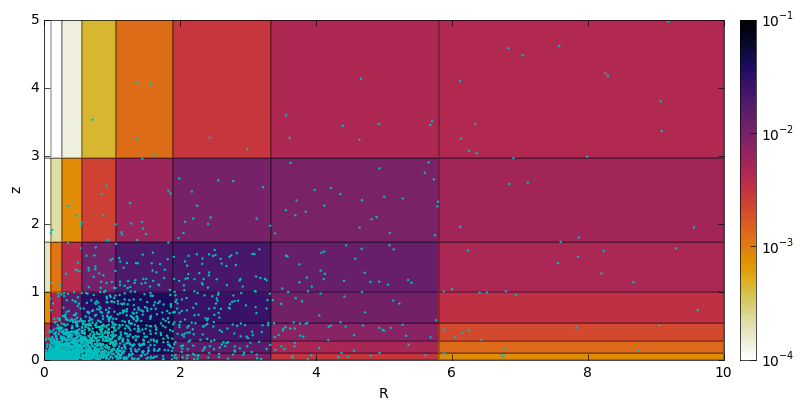

In [5]:
fig = plt.figure(figsize=(8, 4))
axh = plt.axes([0.05, 0.12, 0.85, 0.85], aspect='equal')
axc = plt.axes([0.92, 0.12, 0.02, 0.85])
mesh = axh.pcolormesh(gridR, gridz, constraints_density.reshape(len(gridz)-1, len(gridR)-1),
    edgecolor=[0,0,0,0.25], lw=0.5, norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e-1), cmap='hell_r')
fig.colorbar(mesh, cax=axc)
ic_R = (ic[:,0]**2 + ic[:,1]**2)**0.5
ic_z = abs(ic[:,2])
axh.scatter(ic_R, ic_z, color='c', marker='o', lw=0, s=3)
axh.set_xlim(min(gridR), max(gridR))
axh.set_ylim(min(gridz), max(gridz))
axh.set_xlabel('R')
axh.set_ylabel('z')
None

#### Building the orbit library

Now it is time to construct the orbit library, which is performed by the `orbit` routine discussed in `tutorial_potential_orbits`. As usual, we need to provide the potential, initial conditions, duration of orbit integration (here we use 100 orbital periods for each point, which is pretty common), and the new thing is that we also provide our `Target` that will collect the fraction of time each orbit spends in each cell. The `orbit` routine returns the matrices $\mathsf{D}$ (one for each Target) and the array of `Orbit` interpolator objects (as requested by `dtype=object`).

In [6]:
matrix_density, orbits = agama.orbit(
    potential=pot_total,
    ic=ic,
    time=100*pot_total.Tcirc(ic),
    dtype=object,
    targets=target_density)

2000 orbits complete (299.6 orbits/s)                  


We can visualize a few orbits (most of them look pretty similar in an axisymmetric system, covering a distorted rectangular region in the meridional plane), and verify that rows of matrix $\mathsf{D}$ indeed contain the fraction of time an orbit spends in each cell.<br>
The cyan points are taken from the trajectory at equal times, and of course are denser around the boundaries of the orbit (since it slows down near turnaround points). The color shading of the 2d grid indeed follows the density of sampled points.

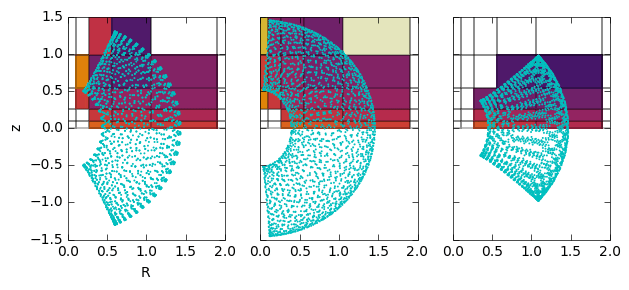

In [7]:
def show_orbit(index, ax):
    orbit = orbits[index]
    t = numpy.linspace(orbit[0], orbit[-1], 2500)  # show the orbit at equally spaced moments in time
    xv = orbit(t)
    orbit_R = (xv[:,0]**2 + xv[:,1]**2)**0.5
    orbit_z = xv[:,2]
    ax.pcolormesh(gridR, gridz, matrix_density[index].reshape(len(gridz)-1, len(gridR)-1),
        edgecolor=(0,0,0,0.25), lw=0.5, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1), cmap='hell_r')
    ax.scatter(orbit_R, orbit_z, color='c', marker='o', lw=0, s=2)

# pick up a few orbits with mean radii around unity, but different inclinations
orbit_radius = numpy.mean(pot_total.Rperiapo(ic), axis=1)
num_show = 3
select = numpy.argsort(abs(orbit_radius - 1.0))[:num_show]
ax = plt.subplots(1, num_show, figsize=(6.4, 3), sharex=True, sharey=True)[1]
for i in range(num_show):
    show_orbit(select[i], ax[i])
ax[0].set_xlim(0, 2)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_xlabel('R')
ax[0].set_ylabel('z')
plt.tight_layout()

#### Determining the orbit weights

Now that we have both the matrix $\mathsf{D}$ and the rhs vector of constraints $\boldsymbol{r}$, 
we can solve the linear optimization problem defined above to determine the orbit weights. The array returned by the `orbit` routine has $N_\text{orbits}$ rows and $N_\text{constraints}$ columns, so needs to be transposed to act as the matrix $\mathsf{D}$ in the linear system. The solution is obtained with the `solveOpt` routine; it delegates the task to a third-party quadratic optimization solver `CVXOPT`, which needs to be enabled during the compilation of the `Agama` library (otherwise you will see an error).

In [8]:
weights = agama.solveOpt(matrix=matrix_density.T, rhs=constraints_density)
print('Orbit weights: %s, total mass: %g' % (weights, sum(weights)))

Using a custom optimized KKT solver
numVariables=2000, numConstraints=56, numConsIneq=2000
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  4e+01  4e+01  1e+00
 1:  0.0000e+00 -1.8881e-01  1e+02  9e+00  9e+00  4e-03
 2:  0.0000e+00 -3.7799e-03  1e-01  3e-01  3e-01  2e-03
 3:  0.0000e+00 -5.3067e-04  1e-02  7e-02  7e-02  1e-03
 4:  0.0000e+00 -1.2762e-04  1e-03  2e-02  2e-02  4e-04
 5:  0.0000e+00 -4.7440e-05  3e-04  7e-03  7e-03  1e-04
 6:  0.0000e+00 -1.7388e-05  6e-05  2e-03  2e-03  2e-05
 7:  0.0000e+00 -1.9528e-05  5e-05  1e-03  1e-03  9e-06
 8:  0.0000e+00 -1.5571e-06  4e-06  9e-05  9e-05  5e-07
 9:  0.0000e+00 -1.7347e-08  4e-08  1e-06  1e-06  5e-09
10:  0.0000e+00 -1.7345e-10  4e-10  1e-08  1e-08  5e-11
Optimal solution found.
Orbit weights: [ 0.00028956  0.0007117   0.00023347 ...,  0.00041547  0.00086999
  0.00039203], total mass: 0.991573


The output messages from the solver are somewhat cryptic, but the "Optimal solution found" message is reassuring.

A slight defect is that the weights do not sum up to unity: since the solver was requested only to match the masses inside each cell of the finite grid, it can do whatever it wants to the weights of orbits that do not contribute to any cell at all (i.e. are located at large radii).<br>
We can remedy it by providing another constraint – the total mass of the density profile. As explained above, one can stack multiple matrices $\mathsf{D}^{(k)}$ and rhs vectors $\boldsymbol{r}^{(k)}$, and to avoid copying the data, the `solveOpt` routine can take a list of matrices and rhs vectors. For the total mass constraint, we have just one number (but it still needs to be a vector of length one), and the corresponding matrix $\mathsf{D}$ contains one row filled with ones (since each orbit's contribution to the model mass is its own weight).

In [9]:
weights = agama.solveOpt(
    matrix=[matrix_density.T, numpy.ones((1, Norbits))],
    rhs=[constraints_density, [total_mass]])
print('Orbit weights: %s, total mass: %g' % (weights, sum(weights)))

Using a custom optimized KKT solver
numVariables=2000, numConstraints=57, numConsIneq=2000
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  4e+01  4e+01  1e+00
 1:  0.0000e+00 -1.8799e-01  1e+02  9e+00  9e+00  4e-03
 2:  0.0000e+00 -4.5311e-03  2e-01  3e-01  3e-01  2e-03
 3:  0.0000e+00 -6.2163e-04  1e-02  8e-02  8e-02  1e-03
 4:  0.0000e+00 -1.5047e-04  2e-03  3e-02  3e-02  5e-04
 5:  0.0000e+00 -5.8236e-05  4e-04  9e-03  9e-03  1e-04
 6:  0.0000e+00 -2.9118e-05  1e-04  4e-03  4e-03  5e-05
 7:  0.0000e+00 -1.1639e-05  4e-05  1e-03  1e-03  1e-05
 8:  0.0000e+00 -9.4330e-06  2e-05  4e-04  4e-04  3e-07
 9:  0.0000e+00 -2.2155e-07  5e-07  1e-05  1e-05  7e-09
10:  0.0000e+00 -2.2159e-09  5e-09  1e-07  1e-07  7e-11
11:  0.0000e+00 -2.2158e-11  5e-11  1e-09  1e-09  7e-13
Optimal solution found.
Orbit weights: [ 0.00029504  0.00071323  0.00023306 ...,  0.0004145   0.00086981
  0.00039151], total mass: 1


Now the total mass is also perfectly matched, and the orbit weights have changed very little.

The solution of the optimization problem is not always successful, however.<br>
Let us see what happens if we provide only half of the orbit library (the initial conditions are drawn randomly, so any subset of orbits is still a fair sampling of the model, but it turns out to be insufficient to satisfy all constraints).

In [10]:
Norbits2 = Norbits//2
try:
    weights2 = agama.solveOpt(
        matrix=[matrix_density[:Norbits2].T, numpy.ones((1, Norbits2))],
        rhs=[constraints_density, [total_mass]])
except Exception as e:
    print(e)

Using a custom optimized KKT solver
numVariables=1000, numConstraints=57, numConsIneq=1000
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  3e+01  1e+00
 1:  0.0000e+00 -1.8749e-01  7e+01  6e+00  6e+00  4e-03
 2:  0.0000e+00 -7.8288e-03  3e-01  4e-01  4e-01  4e-03
 3:  0.0000e+00 -1.7196e-03  4e-02  1e-01  1e-01  2e-03
 4:  0.0000e+00 -3.7513e-04  7e-03  5e-02  5e-02  1e-03
 5:  0.0000e+00 -2.7938e-04  1e-02  5e-02  5e-02  1e-03
 6:  0.0000e+00  3.4424e-04  1e-02  4e-02  4e-02  2e-03
 7:  0.0000e+00  2.4124e-03  5e-02  5e-02  5e-02  4e-03
 8:  0.0000e+00  9.5404e-02  1e+00  5e-02  5e-02  1e-01
 9:  0.0000e+00  9.6092e+00  1e+02  5e-02  5e-02  1e+01
10:  0.0000e+00  9.6101e+02  1e+04  5e-02  5e-02  1e+03
11:  0.0000e+00  9.6101e+04  1e+06  5e-02  5e-02  1e+05
12:  0.0000e+00  9.6101e+06  1e+08  5e-02  5e-02  1e+07
Certificate of primal infeasibility found.
Error in solveOpt(): quadraticOptimizationSolve: problem is infeasible


The specific error message may vary; sometimes it complains about rank-deficient matrices, and the most common failure mode is that the solution does not converge in 100 iterations, while pcost/dcost reach even higher values. In any case, it was not possible to find a solution of our linear system with all weights being non-negative.

So instead we may ask for an *approximate* solution, providing some finite uncertainties $\epsilon_c$ for our constraints (for instance, a fixed relative error of 1 percent). This is effected by adding the `rpenq` parameter ("q" stands for a quadratic penalty as explained at the beginning, and "r" is the penalty for constraints; it is also possible to add linear or quadratic penalties for the vector of unknowns, i.e. weights). The quadratic form $\mathcal Q$ is diagonal in our case, and its elements are inverse squares of uncertainties, just as in the standard linear least-square fitting problem (which is exactly what we are doing here, except that we also add the non-negativity requirement for the solution vector). An infinite penalty means that the corresponding constraint has to be satisfied exactly (we use this for the total mass, since it is almost always pretty easy to satisfy).

After obtaining the new vector of weights that solve the linear system approximately, we may examine which constraints were not satisfied (i.e. where the product of matrix $\mathsf{D}$ times the solution vector $\boldsymbol w$ does not match the rhs $\boldsymbol{r}$).

In [11]:
constraints_density_uncertainty = 0.01 * constraints_density
weights2 = agama.solveOpt(
    matrix=[matrix_density[:Norbits2].T, numpy.ones((1, Norbits2))],
    rhs=[constraints_density, [total_mass]],
    rpenq=[constraints_density_uncertainty**-2, [numpy.inf]])

def check_solution():
    actual_density = matrix_density[:Norbits2].T.dot(weights2)
    bad_cells = numpy.where(abs(actual_density - constraints_density) > constraints_density_uncertainty)[0]
    for c in bad_cells:
        print('cell %s, required mass=%g, actual mass=%g, difference=%.3g%%' %
            (target_density[c], constraints_density[c], actual_density[c],
             (actual_density[c]/constraints_density[c]-1)*100))

check_solution()

Using a custom optimized KKT solver
numVariables=1056, numConstraints=57, numConsIneq=1000
     pcost       dcost       gap    pres   dres
 0:  3.4689e-10 -1.0074e+00  1e+03  3e+01  3e+01
 1:  2.9849e-09 -1.0038e+00  2e+01  7e-01  7e-01
 2:  2.3939e-06 -9.6087e-01  7e+00  2e-01  2e-01
 3:  3.7126e-05 -8.4922e-01  3e+00  7e-02  7e-02
 4:  1.9313e-04 -6.1909e-01  2e+00  4e-02  4e-02
 5:  7.4607e-04 -4.6336e-01  2e+00  3e-02  3e-02
 6:  5.5902e-03  8.5202e-02  2e+00  3e-02  3e-02
 7:  3.5131e-02  1.2052e+00  2e+00  2e-02  2e-02
 8:  1.4255e-01  3.0186e+00  2e+00  2e-02  2e-02
 9:  1.2356e+00  9.3362e+00  3e+00  2e-02  2e-02
10:  2.7341e+00  1.3348e+01  4e+00  2e-02  2e-02
11:  6.9699e+00  1.9294e+01  6e+00  1e-02  1e-02
12:  7.5702e+00  1.9701e+01  6e+00  1e-02  1e-02
13:  9.5288e+00  2.1197e+01  6e+00  1e-02  1e-02
14:  1.7414e+01  2.3979e+01  5e+00  6e-03  5e-03
15:  2.3982e+01  2.5534e+01  2e+00  1e-03  1e-03
16:  2.6090e+01  2.5886e+01  2e-01  8e-06  8e-06
17:  2.6074e+01  2.5998e+01 

So it was struggling to satisfy a few cell masses in the outskirts of the model, and the discrepancy does not exceed a few percent – we might declare it insignificant, but it is always worth checking.

One can also use a *linear* (not *quadratic*) penalty for density constraints (passing it as a `rpenl` argument); this adds a term<br>
$\displaystyle \sum\limits_{c=1}^{N_\text{constraints}} \left| \frac{\displaystyle \sum\nolimits_{i=1}^{N_\text{orbits}} D_{c,i}\, w_i - r_c}{\displaystyle \epsilon_c} \right|$<br>
to the objective function $\mathcal Q$. The advantage of this "$L_1$ penalty" is that it minimizes the number of rows in the linear system that cannot be satisfied exactly, rather than "spreading the problem" over a larger number of rows but with smaller deviations in each.

In [12]:
weights2 = agama.solveOpt(
    matrix=[matrix_density[:Norbits2].T, numpy.ones((1, Norbits2))],
    rhs=[constraints_density, [total_mass]],
    rpenl=[constraints_density_uncertainty**-1, [numpy.inf]])
check_solution()

Using a custom optimized KKT solver
numVariables=1112, numConstraints=57, numConsIneq=1112
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  5e+07  3e+01  1e-06  1e+00
 1: -1.1109e+00 -1.0430e+00  1e+06  7e-01  3e-08  9e-02
 2: -2.2343e+01 -2.1797e+01  1e+06  7e-01  3e-08  6e-01
 3: -2.5737e+01 -2.5497e+01  2e+05  1e-01  6e-09  2e-01
 4: -1.0680e+02 -1.0613e+02  2e+05  1e-01  5e-09  7e-01
 5: -1.7797e+02 -1.7717e+02  9e+04  6e-02  2e-09  8e-01
 6: -1.1949e+02 -1.1928e+02  1e+04  6e-03  3e-10  2e-01
 7: -3.3563e+02 -3.3515e+02  9e+03  6e-03  2e-10  5e-01
 8: -1.0205e+03 -1.0192e+03  8e+03  5e-03  2e-10  1e+00
 9: -1.4932e+03 -1.4913e+03  2e+03  1e-03  5e-11  2e+00
10: -5.9573e+02 -5.9499e+02  8e+02  5e-04  2e-11  7e-01
11: -1.9660e+02 -1.9635e+02  3e+02  2e-04  7e-12  2e-01
12: -1.7903e+02 -1.7881e+02  2e+02  2e-04  6e-12  2e-01
13: -9.0931e+01 -9.0814e+01  1e+02  8e-05  3e-12  1e-01
14: -4.3927e+01 -4.3863e+01  7e+01  5e-05  2e-12  6e-02
15: -6.2069e+00

#### Creating N-body snapshots

One of the applications of the method is the construction of equilibrium initial conditions for $N$-body simulations, so we would like to create an $N$-body snapshot from our orbit-superposition model.

During the orbit integration, we already stored the trajectories represented by `Orbit` classes (a thin wrapper on top of spline interpolators). Now it is fairly easy to sample the required number of points from each trajectory, in proportion to its weight in the model. This task is performed by the routine `sampleOrbitLibrary`, which returns a success flag (True/False) and the result.
Since the orbit interpolators can be sampled with as many points as needed, the procedure always succeeds; had we chosen to store trajectories as arrays of fixed (predetermined) size, it may have failed if the number of samples drawn from some high-weight orbits exceeds the size of recorded trajectories, necessitating to re-integrate some orbits. But with interpolators, the procedure is really straightforward.

When running a simulation, we would need to add the central black hole as another particle (initially at rest at origin).

In [13]:
Nbody = 100000
success, (snap_posvel, snap_mass) = agama.sampleOrbitLibrary(Nbody, orbits, weights)
print(success)

True


#### Examining the model

Alright, what can we do with this snapshot?<br>
The first thing to check is whether it is in an equilibrium. The ultimate check would be to run an actual $N$-body simulation, which is beyond the scope of this tutorial), but a weaker check is to examine the virial ratio (the ratio of kinetic and potential energy), which should be close to unity. The kinetic energy can be computed directly from particles, and the potential energy – well, we can use the `Multipole` potential constructed from the particle snapshot.

In [14]:
pot_stars_nbody = agama.Potential(type='multipole', particles=(snap_posvel, snap_mass), symmetry='a')
E_kin = 0.5 * numpy.sum(snap_mass[:,None] * snap_posvel[:,3:6]**2)
E_pot = 0.5 * numpy.sum(snap_mass * pot_stars_nbody.potential(snap_posvel[:,0:3]))
print('Epot=%g, Ekin=%g, virial ratio=%g' % (E_pot, E_kin, -2*E_kin/E_pot))

Epot=-0.461895, Ekin=0.343404, virial ratio=1.48694


Bang, something is wrong! The virial ratio should be around unity, but it is not.

We forgot that our model had a second component – a central black hole. It contributes nothing to the kinetic energy, but quite a lot to the potential energy; we need to use the _total_ potential when summing over all particles' $E_\text{pot}$, and also add $E_\text{pot}$ of the black hole itself – it is evaluated in the stellar potential only (not including its own potential, which would make the energy infinite).

In [15]:
E_pot += 0.5 * (numpy.sum(snap_mass * pot_bh.potential(snap_posvel[:,0:3])) +
    pot_bh.totalMass() * pot_stars_nbody.potential(0,0,0))
print('Epot=%g, Ekin=%g, virial ratio=%g' % (E_pot, E_kin, -2*E_kin/E_pot))

Epot=-0.687885, Ekin=0.343404, virial ratio=0.998435


Okay, now this looks sensible, at least the ratio is around unity – probably the model is indeed close to equilibrium (unless it somehow managed to have wrong values of both kinetic and potential energy).<br>
For the peace of mind, let us compute the expected value of the potential energy from the definition:<br>
$\displaystyle E_\text{pot} = \frac{1}{2} \iiint \rho(\boldsymbol{x})\, \Phi(\boldsymbol{x})\, d^3 x = \frac{1}{2} \int_0^\infty dr\, r^2  \int_0^\pi d\theta\, \sin\theta \int_0^{2\pi} d\phi\; \rho(r,\theta,\phi)\,\Phi(r,\theta,\phi)$.<br>
In the case of axisymmetric systems, the integral over the azimuthal angle $\phi$ is trivial, and the remaining two spatial dimensions ($\theta$ and $r$) need to be integrated over numerically. We use the `integrateNdim` function from `Agama`, which integrates over a finite region (2d rectangle in our case), so we change variables from $\{r,\theta\}$ to $\{\xi \equiv \tanh r \in [0..1), \eta \equiv \cos\theta\}$. The integral is written as<br>
$\displaystyle E_\text{pot} = \frac{1}{2} \int_0^1 d\xi\, \frac{2\pi\,\text{arctanh}^2\xi}{1-\xi^2} \int_{-1}^1 d\eta\; \rho\,\Phi$.<br>
As explained above, we need to use the total potential (including the central BH) as $\Phi$, but only the density of stars as $\rho$, and separately add the potential energy of the central BH in the stellar potential.

In [16]:
def compute_potential_energy(density, potential):
    def integrand(var):
        xi, costheta = var.T
        sintheta = (1-costheta**2)**0.5
        r = numpy.arctanh(xi)
        jac = 2*numpy.pi * r**2 / (1-xi**2)
        x = numpy.column_stack((r * sintheta, r * 0, r * costheta))
        return numpy.nan_to_num(density.density(x) * potential.potential(x) * jac)
    with numpy.errstate(all='ignore'):
        # ignore warnings about invalid values when evaluating integrand at infinity and suchlike
        return 0.5 * agama.integrateNdim(integrand, lower=[0,-1], upper=[1,1])[0]

E_pot_true = (compute_potential_energy(dens_stars, pot_total) +
    0.5 * pot_bh.totalMass() * pot_stars.potential(0,0,0))
print('True Epot=%g; fractional difference from Nbody: %.2g' % (E_pot_true, E_pot/E_pot_true-1))

True Epot=-0.695364; fractional difference from Nbody: -0.011


So indeed, the $N$-body system has very nearly the same potential energy as the smooth model, and likely close to equilibrium – to be entirely sure, one would need to run the full $N$-body simulation.

The next thing we can check is the shape of the $N$-body snapshot. The standard method for computing the shape from the moment of inertia tensor can be applied to the snapshot itself (and there is an implementation of this method included in the repository as `measureshape.py`), but for simplicity, we will use the above constructed `Multipole` approximation of the snapshot, which (as any density model in `Agama`) also provides a method for computing the principal axes. The ratio of smallest to largest axes should be similar to the flattening $q$ of our input density profile.

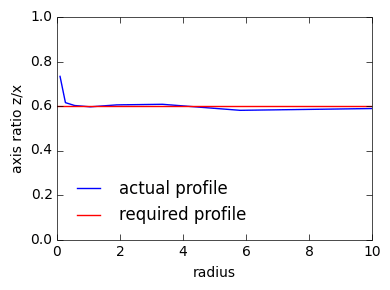

In [17]:
axes = pot_stars_nbody.principalAxes(gridR)[0]
plt.figure(figsize=(4,3))
plt.plot(gridR, axes[:,2] / axes[:,0], c='b', label='actual profile')
plt.axhline(q, color='r', label='required profile')
plt.xlim(min(gridR), max(gridR))
plt.ylim(0, 1)
plt.xlabel('radius')
plt.ylabel('axis ratio z/x')
plt.legend(loc='lower left', frameon=False)
plt.tight_layout()

Also looks good. The slight deviation in the inner part may be due to insufficient resolution of our spatial grid – the innermost radius was set to 0.1, and since there is only one square cell near the origin, the shape of the density profile at small radii is not constrained at all. Later we will see how to improve it, but for now let's turn to another sanity check: the velocity distributions of particles. We can compute three velocity components in spherical coordinates, and plot them against spherical radius, to see if the model looks sensible.

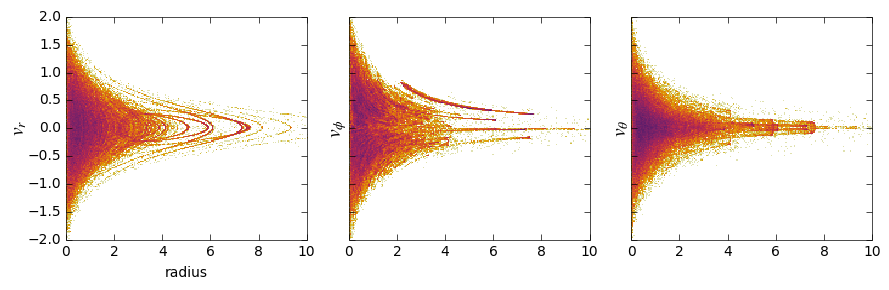

In [18]:
snap_R  = numpy.sum(snap_posvel[:,0:2]**2, axis=1)**0.5
snap_r  = numpy.sum(snap_posvel[:,0:3]**2, axis=1)**0.5
snap_vr = numpy.sum(snap_posvel[:,0:3] * snap_posvel[:,3:6], axis=1) / snap_r
snap_vphi = (snap_posvel[:,0] * snap_posvel[:,4] - snap_posvel[:,1] * snap_posvel[:,3]) / snap_R
snap_vtheta = (numpy.sum(snap_posvel[:,0:2] * snap_posvel[:,3:5], axis=1) / snap_R * snap_posvel[:,2] 
    - snap_R * snap_posvel[:,5]) / snap_r

ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)[1]
bins_r = numpy.linspace(0, 10, 200)
bins_v = numpy.linspace(-2, 2, 200)
hist_params = dict(
    bins=(bins_r, bins_v),
    weights=snap_mass / (bins_r[1]-bins_r[0]) / (bins_v[1]-bins_v[0]),
    norm=matplotlib.colors.LogNorm(vmin=5e-3, vmax=5),
    cmap='hell_r')
ax[0].hist2d(snap_r, snap_vr, **hist_params)
ax[1].hist2d(snap_r, snap_vphi, **hist_params)
ax[2].hist2d(snap_r, snap_vtheta, **hist_params)
ax[0].set_xlabel('radius')
ax[0].set_ylabel(r'$v_r$', labelpad=0, fontsize=14)
ax[1].set_ylabel(r'$v_\phi$', labelpad=0, fontsize=14)
ax[2].set_ylabel(r'$v_\theta$', labelpad=0, fontsize=14)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(-2, 2)
plt.tight_layout()

Hmmm, not quite perfect – the inner regions seem to be well mixed, but in the outskirts, there are clear patterns apparently tracing out individual orbits. This may happen if the size of the orbit library is not large enough, and some orbits get particularly high weights. We may see this from the weight distribution of orbits plotted against radius – indeed, there are a few that stand out at large radii.

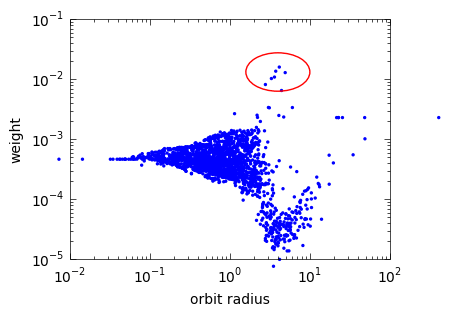

In [19]:
plt.figure(figsize=(4,3))
ax = plt.axes([0.18, 0.18, 0.8, 0.8])
ax.scatter(orbit_radius, weights, s=2, color='b', clip_on=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2, 1e2)
ax.set_ylim(1e-5, 1e-1)
ax.set_xlabel('orbit radius')
ax.set_ylabel('weight')
ax.add_artist(matplotlib.patches.Ellipse((0.65, 0.78), 0.2, 0.16, fill=False, color='r', transform=ax.transAxes))
None

If we repeat this exercise with a larger number of orbits (say, 10000 or more), these patterns virtually disappear.

#### Velocity anisotropy profiles

Instead of looking at 2d distributions of radius vs. velocity, we can condense them into the 1d velocity anisotropy profile: $\displaystyle \beta(r) \equiv 1 - \frac{1}{2} \frac{\sigma_\text{tan}^2}{\sigma_\text{rad}^2}$, where the radial and tangential velocity dispersions are $\sigma_\text{rad}^2 = \overline{v_r^2}$ and $\sigma_\text{tan}^2 = \overline {v_\theta^2} + \overline{v_\phi^2}$.

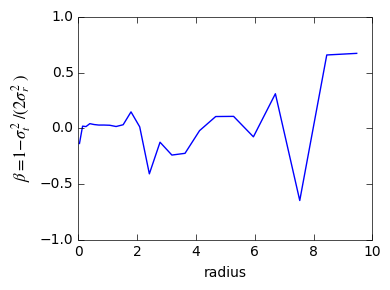

In [20]:
def plot_beta_profile(snap_posvel, snap_mass):
    snap_r   =  numpy.sum(snap_posvel[:,0:3]**2, axis=1)**0.5
    snap_vr2 = (numpy.sum(snap_posvel[:,0:3] * snap_posvel[:,3:6], axis=1) / snap_r)**2
    snap_vt2 = (numpy.sum(snap_posvel[:,3:6]**2, axis=1) - snap_vr2)
    bins_r   = agama.nonuniformGrid(25, 0.1, 10)
    hist_vr2 = numpy.histogram(snap_r, bins=bins_r, weights=snap_mass * snap_vr2)[0]
    hist_vt2 = numpy.histogram(snap_r, bins=bins_r, weights=snap_mass * snap_vt2)[0]
    plt.figure(figsize=(4,3))
    plt.plot((bins_r[1:]+bins_r[:-1])/2, 1 - 0.5 * hist_vt2 / hist_vr2, label='actual profile', color='b')
    plt.xlim(min(bins_r), max(bins_r))
    plt.ylim(-1, 1)
    plt.xlabel('radius')
    plt.ylabel(r'$\beta = 1 - \sigma_t^2 / (2\sigma_r^2)$', fontsize=12)
    plt.tight_layout()

plot_beta_profile(snap_posvel, snap_mass)

This looks somewhat jagged (likely reflecting the undesirable structures in the velocity distributions at large radii shown earlier), but in general quite close to isotropy ($\beta=0$). We have not explicitly set any constraints on the velocity anisotropy, so this result is largely determined by the initial conditions of the orbit library, which were indeed sampled with isotropic velocities (more on that later).

We can actually set some constraints on the $\beta$ profile, but for this, we should have recorded some velocity information from individual orbits, not just their density contributions. This task is performed by another type of `Target` object, which records the integrals of radial and tangential velocity dispersions over spherical shells:
$\displaystyle E_{\text{rad},s} \equiv \iiint_{\boldsymbol x\in S_s} \rho(\boldsymbol{x})\, v_r^2 \; d^3x$ and similarly for $E_\text{tan}$,
where $S_s$ is the spatial region occupied by $s$-th shell. This is similar to the spatial grid for density discretization, but simpler in the sense of using just a 1d grid in spherical radius; OTOH we record two components of velocity dispersions, hence the size of this dataset is twice the size of the grid.

We create an instance of this kinematic target, and can apply it to the already computed orbit library.  A better way would be to pass it along with the density target during the construction of the orbit library from the very beginning, as shown in the last statement.

In [21]:
target_kinem = agama.Target(type='KinemShell', gridr=gridR, degree=1)   # "degree" will be explained later

try:
    matrix_kinem = target_kinem(orbits)
except TypeError:
    # the above feature is not available in older versions of the library; as a fallback, we need to construct
    # the orbit library again while providing both target objects to collect data during orbit integrations
    matrix_density, matrix_kinem, orbits = agama.orbit(
        potential=pot_total,
        ic=ic,
        time=100*pot_total.Tcirc(ic),
        dtype=object,
        targets=[target_density, target_kinem])

Now we can use the same already constructed orbit library to create variants of models with different anisotropy profiles $\beta(r)$.

The procedure for adding the anisotropy constraint to the linear system is slighly more complicated, since we need to express it as a linear function of recorded velocity dispersions that will be multiplied by orbit weights to produce some required value in the r.h.s.
By rearranging the definition of the anisotropy parameter, we obtain $2 \big[1-\beta(r)\big] \sigma_\text{rad}^2 - \sigma_\text{tan}^2 = 0$. The l.h.s. is a function sampled for each orbit at the values of radii provided to the Target object, and we can put any desired profile of $\beta(r)$ into this expression to obtain the *transformed* matrix of orbit contributions to each kinematic constraint; the r.h.s. is always zero.<br>
The helper function below takes the profile $\beta(r)$ and creates this transformed matrix, then solves the optimization problem to obtain orbit weights, and creates an $N$-body representation of this model, from which we may plot the resulting anisotropy profile just as in the previous fragment. 
This time there will be three matrices and three sets of constraints: density discretized on the grid, kinematics (on a different grid), and total mass. Of these, the first and the last sets are specified as equality constraints, but because not all possible $\beta$ profiles can be reproduced exactly, we assign some finite penalty for violating these kinematic constraints (just as we did earlier with density constraints in a small orbit library). 

In [22]:
def solve_with_beta_profile(beta_profile):
    Ngrid = len(target_kinem) // 2
    # Ngrid values of rho sigma_r^2, then the same number of values of rho sigma_t^2;
    # we combine them into a single array of Ngrid values that enforce isotropy (sigma_t^2 - 2 sigma_r^2 = 0)
    matrix_kinem_transformed = 2 * (1 - beta_profile(gridR)) * matrix_kinem[:,:Ngrid] - matrix_kinem[:,Ngrid:]
    constraints_kinem  = numpy.zeros(Ngrid)
    weights = agama.solveOpt(matrix=[matrix_density.T, matrix_kinem_transformed.T, numpy.ones((1, Norbits))], 
        rhs=[constraints_density, constraints_kinem, [1.0]],
        rpenq=[constraints_density*numpy.inf, numpy.ones(Ngrid), [numpy.inf]])
    return agama.sampleOrbitLibrary(Nbody, orbits, weights)[1]

Let us illustrate this for two different choices of anisotropy profile: the first starts from $\beta=0$ zero and gradually becomes more radially anisotropic at large radii (though not as quickly as the commonly used Osipkov–Merritt profile), and the second is a constant mild tangential anisotropy $\beta=-0.5$.

Using a custom optimized KKT solver
numVariables=2009, numConstraints=66, numConsIneq=2000
     pcost       dcost       gap    pres   dres
 0:  6.7882e-06 -1.0058e+00  2e+03  4e+01  5e+01
 1:  2.5018e-05 -1.0040e+00  3e+01  7e-01  7e-01
 2:  2.4864e-04 -9.3705e-01  6e+00  1e-01  1e-01
 3:  4.1132e-04 -7.3060e-01  2e+00  3e-02  3e-02
 4:  4.6944e-04 -4.6707e-01  8e-01  1e-02  1e-02
 5:  4.8717e-04 -3.0432e-01  4e-01  5e-03  5e-03
 6:  4.3801e-04 -1.0942e-01  1e-01  1e-03  1e-03
 7:  2.6547e-04 -2.9891e-02  3e-02  2e-04  2e-04
 8:  9.7027e-05 -4.5952e-03  5e-03  3e-05  3e-05
 9:  4.7221e-05 -2.5502e-03  3e-03  1e-05  1e-05
10:  1.8177e-05 -5.2307e-04  5e-04  2e-06  2e-06
11:  1.0919e-05 -3.8817e-04  4e-04  9e-07  9e-07
12:  4.8154e-06 -1.3947e-04  1e-04  2e-07  2e-07
13:  2.4026e-06 -8.5438e-05  9e-05  7e-08  7e-08
14:  1.2040e-06 -6.3766e-05  6e-05  3e-08  3e-08
15:  1.7951e-06 -6.1653e-05  6e-05  2e-08  2e-08
16:  1.2261e-06 -4.5593e-05  5e-05  1e-08  1e-08
17:  3.9135e-07 -9.7952e-06 

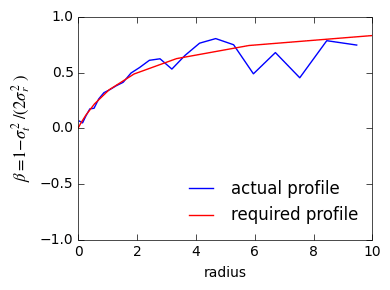

In [23]:
beta_profile_radially_anisotropic = lambda r: r / (r + 2.0)
snap_posvel_rad, snap_mass_rad = solve_with_beta_profile(beta_profile_radially_anisotropic)
plot_beta_profile(snap_posvel_rad, snap_mass_rad)
plt.plot( gridR, beta_profile_radially_anisotropic(gridR), color='r', label='required profile')
plt.legend(loc='lower right', frameon=False)
None

Using a custom optimized KKT solver
numVariables=2009, numConstraints=66, numConsIneq=2000
     pcost       dcost       gap    pres   dres
 0:  8.2403e-07 -1.0054e+00  2e+03  4e+01  5e+01
 1:  5.1177e-06 -1.0035e+00  3e+01  7e-01  7e-01
 2:  8.8737e-04 -9.3544e-01  6e+00  1e-01  1e-01
 3:  3.0366e-03 -7.2966e-01  2e+00  3e-02  3e-02
 4:  3.1675e-03 -4.6611e-01  8e-01  1e-02  1e-02
 5:  2.8101e-03 -2.9920e-01  4e-01  5e-03  5e-03
 6:  1.7667e-03 -1.0689e-01  1e-01  1e-03  1e-03
 7:  4.5256e-04 -3.0214e-02  3e-02  1e-04  1e-04
 8:  2.8899e-05 -4.0607e-03  4e-03  1e-05  1e-05
 9:  2.1284e-06 -4.4224e-04  4e-04  3e-14  6e-16
10:  1.3210e-06 -6.6742e-05  7e-05  2e-14  9e-17
11:  8.7288e-07 -3.0665e-05  3e-05  3e-14  3e-17
12:  4.3938e-07 -2.9139e-05  3e-05  2e-14  2e-17
13:  1.2425e-07 -8.2492e-06  8e-06  8e-15  7e-18
14:  7.9231e-08 -4.4473e-06  5e-06  2e-14  2e-18
15:  4.1901e-08 -2.2947e-06  2e-06  2e-14  9e-19
16:  9.6973e-09 -1.3660e-06  1e-06  1e-14  5e-19
17:  4.3737e-10 -1.0986e-07 

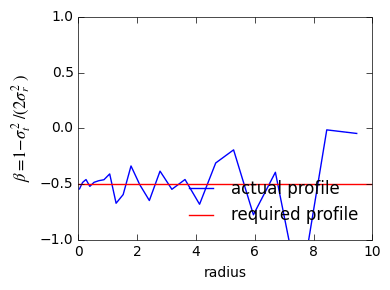

In [24]:
beta_profile_tangentially_anisotropic = lambda r: -0.5
snap_posvel_tan, snap_mass_tan = solve_with_beta_profile(beta_profile_tangentially_anisotropic)
plot_beta_profile(snap_posvel_tan, snap_mass_tan)
plt.axhline(beta_profile_tangentially_anisotropic(0), color='r', label='required profile')
plt.legend(loc='lower right', frameon=False)
None

#### Different density discretization schemes

So far we have used `Target(type="DensityCylindricalTopHat")`, what other types are available and when to use them?


Another variant is the `DensityClassicTopHat` discretization scheme, which goes back to the original Schwarzschild's paper. In this scheme, there is a grid in radius, and the surface of each spherical shell is divided into cells as follows.
One octant of space ($x,y,z\ge 0$) is partitioned into three spherical rectangles ("panes"), then each pane is divided into $N_\text{strips}^2$ smaller squares. One octant is sufficient for models with at most triaxial symmetry; during orbit integration, point coordinates are taken with absolute values and placed into the corresponding cell.

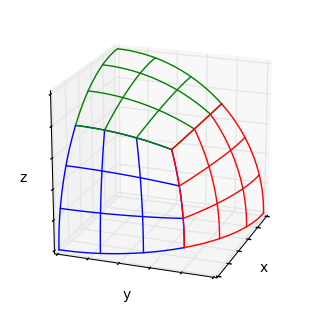

In [25]:
def show_classic_grid(num_strips):
    import mpl_toolkits.mplot3d
    plt.figure(figsize=(3,3))
    ax = plt.axes([0,0,1,1], projection='3d')
    ax.view_init(elev=20, azim=20)
    num_points = 20
    for i in range(num_strips+1):
        alpha = i * numpy.pi/4/num_strips
        betas = numpy.linspace(0, numpy.pi/4, num_points)
        y_over_x = numpy.tan(alpha)
        z_over_x = numpy.tan(betas)
        x,y,z = numpy.array([betas*0+1, betas*0+y_over_x, z_over_x]) / (1 + y_over_x**2 + z_over_x**2)**0.5
        ax.plot(x, y, z, color='b')
        ax.plot(x, z, y, color='b')
        ax.plot(y, z, x, color='g')
        ax.plot(z, y, x, color='g')
        ax.plot(z, x, y, color='r')
        ax.plot(y, x, z, color='r')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
show_classic_grid(3)

The choice of the radial grid is up to the user, and may be guided by the need to resolve some features in the inner part of the galaxy (e.g. the BH sphere of influence), as well as cover nearly all of the mass (say, 99%). An exponentially-spaced radial grid is often a good choice.<br>
One can further compress or stretch the grid along $y$ and $z$ axes by some factors, effectively replacing the spherical radius by elliptical radius; this may be useful for better aligning the grid with the density profile, helping to make cell masses more uniform.
 
Finally, instead of integrating the density $\rho(r,\theta,\phi)$ over the volume of the cells, one can first transform it into a spherical-harmonic expansion, then integrate each term $\rho_{\ell,m}(r)$ over the radial grid shell. This approach is implemented by the `DensitySphHarm` target type.

The optimal choice of the discretization scheme depends on the density profile. Both classic and spherical-harmonic schemes are more suited for models of spheroidal components (bulges, haloes). The radial grid in the classic scheme can be arbitrarily stretched along principal axes, making it more adapted even to highly flattened profiles, but since the way of partitioning the octant into three panes is geared towards triaxial models, it may be less optimal for axisymmetric ones.<br>
OTOH in the spherical-harmonic scheme, one can explicitly specify the orders of expansion $\ell_\text{max}$, $m_\text{max}$, in particular, setting the latter to zero for axisymmetric systems, thereby eliminating redundancy in cell placement. But the downside is that one cannot use elliptical radius in this scheme. <br>
The cylindrical grid may be better suited for disky profiles, and it is also generalized to non-axisymmetric systems by adding the Fourier expansion in $\phi$ up to some $m_\text{max}$, so can represent barred models. However, a separable grid in $R$ and $z$ may not be optimal for some models, where the cells at the corners of the grid may have very stretched shapes and low masses (as in our example above, in which a small orbit library could not satisfy the density constraints at large $R$ and low $z$).

Both cylindrical and classic schemes come in two variants, with "TopHat" and "Linear" suffixes, of which we have used the first one. The "TopHat" in its name refers to the way the cell masses are computed: integrating the density multiplied by a trivial weighting function that is either 1 if the point is inside the cell, or 0 otherwise. However, one can use more complicated weighting functions, in particular, B-splines of some degree $B$ (with a top-hat function being a B-spline of degree zero).

#### Digression: B-splines

This mathematical construct is used in many places throughout the entire `Agama` library and the orbit-superposition module in particular, so it is worth describing its main properties.

B-splines form a basis set defined by the degree $B$ and the grid nodes $x_k$, $k=1..N_\text{grid}$: the interpolated function is represented as a weighted sum of basis functions $\sum_{i=1}^{N_\text{basis}} a_i\, F_i(x)$, where $\boldsymbol a$ is the vector of amplitudes. Each basis function $F_i(x)$ is a polynomial of degree $B$ on at most $B+1$ consecutive grid segments, and zero elsewhere; at grid nodes, the function has $B$ continuous derivatives. For instance, $B=0$ corresponds to top-hat functions that equal 1 inside one segment and 0 elsewhere, so are discontinuous at grid nodes. $B=1$ basis functions linearly rise from 0 to 1 across the grid segment $x_{k-1}$..$x_k$, then linearly fall back to zero on the next segment $x_k..x_{k+1}$. In total, there are $N_\text{basis} = N_\text{grid} + B - 1$ basis functions, illustrated below for a three-segment grid and $B=1,2$:

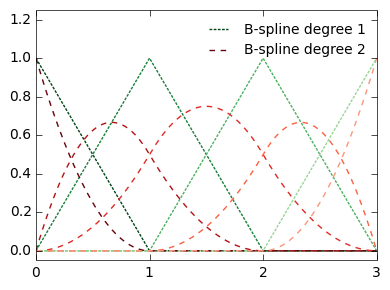

In [26]:
grid_size = 4  # number of nodes; the number of segments is one fewer
grid_nodes = numpy.linspace(0, 3, grid_size)
x = numpy.linspace(grid_nodes[0], grid_nodes[-1], 100*(grid_size-1)+1)  # grid for plotting

# The agama.Spline class can represent different types of splines, and in particular,
# a B-spline interpolator is specified by the grid nodes and a vector of amplitudes.
# To visualize individual basis functions, we provide a vector of amplitudes
# with all zeros except one element.

def show_bspline_functions(degree, cmap, **plot_kwargs):
    basis_size = grid_size + degree - 1
    for i in range(basis_size):
        ampl_i = numpy.eye(basis_size)[i]  # select i-th row of the identity matrix to show one basis function
        basis_fnc = agama.Spline(grid_nodes, ampl=ampl_i)
        plt.plot(x, basis_fnc(x),
            label='B-spline degree %i' % degree if i==0 else None,
            color=plt.get_cmap(cmap)(i*0.8/basis_size), **plot_kwargs)

ax = plt.subplots(1, 1, figsize=(4,3))[1]
show_bspline_functions(1, 'Greens_r', dashes=[2,1])
show_bspline_functions(2, 'Reds_r', dashes=[4,4])
plt.legend(loc='upper right', frameon=False, fontsize=10)
ax.set_xticks(grid_nodes)
ax.set_xlim(min(grid_nodes), max(grid_nodes))
ax.set_ylim(-0.05, 1.25)
plt.tight_layout()

Any given function $g(x)$ can be approximated by a B-spline $\tilde g(x) \equiv \sum_i a_i\,F_i(x)$ using the following approach, which is similar to the Fourier expansion, but generalized to the case of a non-orthonormal basis set.<br>
Define the projection $P_i[g]$ of a function $g(x)$ onto the $i$-th basis function as the inner product of $g(x)$ and the basis function $F_i(x)$, namely $\int g(x)\,F_i(x)\;dx$. We require that the projections of the interpolated function $\tilde g(x)$ coincide with the projections of the original function $g(x)$ for all basis elements. Since $\tilde g$ is a linear combination of basis functions, one can write the vector of its projections as $\boldsymbol P[\tilde g] = \mathsf{M}\,\boldsymbol a$, where the matrix $\mathsf{M}$ contains the pairwise inner products of all basis functions: $M_{i,j} = \int F_i(x)\,F_j(x)\;dx$.<br>
So to find the amplitudes $\boldsymbol a$, we construct the basis matrix $\mathsf{M}$ and compute the vector of projections of the input function $\boldsymbol P[g]$, then solve $\mathsf{M}\,\boldsymbol a = \boldsymbol P[g]$.


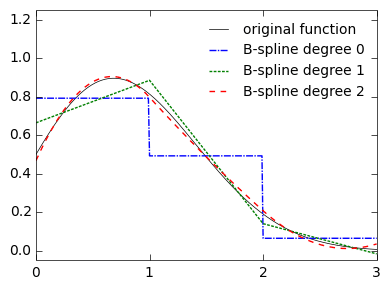

In [27]:
def fnc(x):
    return numpy.exp(-0.5*x*x) * (0.5+numpy.sin(x))

import scipy.integrate

def integrate(integrand):
    # since B-spline basis functions or some of their derivatives are discontinuous at grid nodes,
    # we integrate separately on each grid segment and sum up results, otherwise it would be inaccurate
    return sum([
        scipy.integrate.quad(integrand, grid_nodes[i], grid_nodes[i+1])[0]
        for i in range(len(grid_nodes)-1)
    ])

def compute_projection_fnc(basis_fncs):
    return [
        integrate(lambda x: fnc(x) * basis_fnc(x))
        for basis_fnc in basis_fncs ]

def show_bspline_approximation(degree, compute_projection, ax, **plot_kwargs):
    basis_size = grid_size + degree - 1
    basis_fncs = [
        agama.Spline(grid_nodes, ampl=numpy.eye(basis_size)[i])
        for i in range(basis_size) ]
    basis_matrix = [[
        integrate(lambda x: basis_fncs[i](x) * basis_fncs[k](x))
        for i in range(basis_size) ] 
        for k in range(basis_size) ]
    projection = compute_projection(basis_fncs)
    ampl = numpy.linalg.solve(basis_matrix, projection)
    ax.plot(x, agama.Spline(grid_nodes, ampl=ampl)(x),
        label='B-spline degree %i' % degree, **plot_kwargs)

def show_three_bspline_approximations(ax, compute_projection):
    show_bspline_approximation(0, compute_projection, ax, color='b', dashes=[5,1,1,1])
    show_bspline_approximation(1, compute_projection, ax, color='g', dashes=[2,1])
    show_bspline_approximation(2, compute_projection, ax, color='r', dashes=[4,4])
    ax.set_xticks(grid_nodes)
    ax.set_xlim(min(grid_nodes), max(grid_nodes))
    
ax = plt.subplots(1, 1, figsize=(4,3))[1]
ax.plot(x, fnc(x), c='k', lw=0.5, label='original function')
show_three_bspline_approximations(ax, compute_projection_fnc)
ax.legend(loc='upper right', frameon=False, fontsize=10)
ax.set_ylim(-0.05, 1.25)
plt.tight_layout()

Clearly, higher-degree B-splines are far better at approximating smooth functions (even after adjusting the number of nodes to compensate for extra degrees of freedom for higher-degree splines).

However, this higher accuracy is only achieved for smooth functions that vary on scales larger than the spacing of the B-spline grid. Higher-degree splines still provide some information about features on sub-grid scales, as demonstrated by the following example. Here we push the method to the limit by trying to approximate a delta-function; of course, all spline interpolators will have widths comparable to the grid spacing, but while the location of the delta-function within one grid segment cannot be distinguished in a histogram, it still affects the shape of B-splines of degree 1 and above. Note also that the interpolated functions display some oscillations and attain negative values (Gibbs phenomenon), which is an unavoidable when trying to approximate discontinuous functions with continuous splines.

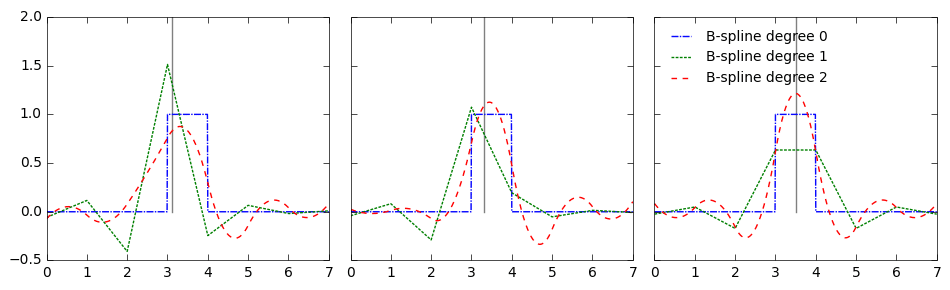

In [28]:
grid_size = 8  # use a larger grid to illustrate the wings of the B-spline approximation
grid_nodes = numpy.linspace(0, 7, grid_size)
x = numpy.linspace(grid_nodes[0], grid_nodes[-1], 100*(grid_size-1)+1)

def compute_projection_deltafnc(x0, ax):
    # for a delta-function, its projection onto the basis is just the values of basis functions at x0
    ax.plot([x0, x0], [0, 2], color='gray')
    return lambda basis_fncs: [basis_fnc(x0) for basis_fnc in basis_fncs]

ax = plt.subplots(1, 3, figsize=(9.6,3), sharex=True, sharey=True)[1]
show_three_bspline_approximations(ax[0], compute_projection_deltafnc(3.1, ax[0]))
show_three_bspline_approximations(ax[1], compute_projection_deltafnc(3.3, ax[1]))
show_three_bspline_approximations(ax[2], compute_projection_deltafnc(3.5, ax[2]))
ax[2].legend(loc='upper left', frameon=False, fontsize=10)
ax[0].set_xticks(grid_nodes)
ax[0].set_xlim(min(grid_nodes), max(grid_nodes))
ax[0].set_ylim(-0.5, 2.0)
plt.tight_layout()

#### Back to discretization schemes

So the two variants of "Classic" and "Cylindrical" density discretization schemes, "TopHat" and "Linear", differ in the degree of B-splines they use for the weighting functions. In the "Linear" variants, a direct product of 1d B-splines of degree 1 is used to associate the mass with grid nodes, rather than grid cells; the integration is carried over two adjacent grid segments in each dimension. These variants should be preferred, since they can both better approximate the smooth input density profile, and resolve the details within grid cells for the orbit-superposition model. For instance, if two orbits have somewhat different spatial extent, but are both confined within one grid cell, the "TopHat" scheme would not distinguish them, whereas "Linear" will be able to assign them different weights depending on the variation of the input density profile within the cell.<br>
It should be stressed that despite the oscillatory nature of higher-degree spline approximations for individual orbits (since they have sharp boundaries), the weighted sum of all orbits still matches the density profile represented by the same spline basis, so should be as smooth as the input density profile.

The `KinemShell` target type is also based on B-splines in radius, and in the above example, we selected degree-1 (linear) B-splines; choices range from 0 to 3, but the advantage of the degree-1 version is that the number of basis functions equals the number of grid nodes, making it easier to specify the required anisotropy profile (with higher-degree B-splines, one would have to go through the projection and matrix inversion process). Note, however, that B-splines are used to represent the integrals $\int \rho\,\sigma_\text{rad,tan}^2\,r^2\;dr$, rather than the anisotropy coefficient $\beta$ (the latter is a ratio of two spline interpolators); nevertheless, providing the $\beta(r)$ profile as the the values at radial grid nodes is a sensible interpretation.

B-splines are also heavily used in the third kind of `Target` objects, `LOSVD`, which will be discussed later in the context of observational applications.

#### Further considerations

##### Initial conditions for the orbit library

In the earlier example, we created the initial conditions by assigning velocities isotropically, using the Eddington-derived DF for a sphericalized input density/potential pair. This may be sufficient for spheroidal systems (even with significant amounts of triaxiality), but in case of disky components, isotropic velocity assignment would be very inefficient, since most orbits will not stay close to the equatorial plane and would not be picked up by the optimization solver.<br>
An alternative approach is based on the auxiliary axisymmetric Jeans model constructed for the given input density/potential pair (using the cylindrically-aligned anisotropic Jeans equations as given, e.g., by eqs 8-11 in [Cappellari 2008](http://adsabs.harvard.edu/abs/2008MNRAS.390...71C); the anisotropy in the meridional plane is controlled by the parameter $\beta_\text{mer} \equiv 1 - \sigma_z^2/\sigma_R^2$). From this model, we obtain the full second moments of velocity in cylindrical coordinates; the $R$ and $z$ components are just the corresponding velocity dispersions, but for the $\overline {v_\phi^2}$ component we have some freedom in splitting it between ordered and random motions, which is controlled by another parameter $\kappa$ ranging from 0 (no net rotation) to $\pm 1$ (near-maximum rotation in either prograde or retrograde direction). Finally, velocities are drawn from a Gaussian distribution with the given dispersions.<br>
This approach is triggered by providing two extra parameters to the `sample` method of the Density class:

In [29]:
ic_rot, _ = dens_stars.sample(Norbits, potential=pot_total, beta=0, kappa=1)

One can verify that these initial conditions indeed have some net rotation (stronger in the very central part due to the presence of the BH).

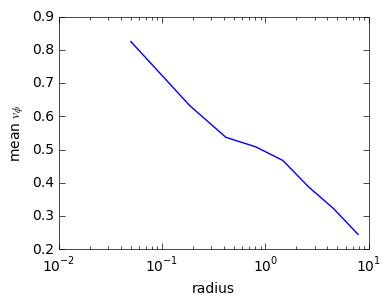

In [30]:
ic_rot_R = (ic_rot[:,0]**2 + ic_rot[:,1]**2)**0.5
ic_rot_vphi = (ic_rot[:,0] * ic_rot[:,4] - ic_rot[:,1] * ic_rot[:,3]) / ic_rot_R
mean_vphi = (numpy.histogram(ic_rot_R, bins=gridR, weights=ic_rot_vphi)[0] /
             numpy.histogram(ic_rot_R, bins=gridR)[0])
plt.figure(figsize=(4,3))
plt.plot(0.5*(gridR[1:]+gridR[:-1]), mean_vphi)
plt.xlabel('radius')
plt.ylabel(r'mean $v_\phi$')
plt.xscale('log')

When building the orbit library with these rotating initial conditions and solving for orbit weights without providing any kinematic constraints, the model ends up being tangentially anisotropic and rotating, as expected. However, it is not difficult to force it to have a desired anisotropy profile (even radial) using the `solve_with_beta_profile` function defined earler. This highlights that when providing kinematic constraints, the choice of orbital initial conditions does not play a major role in the properties of the resulting model; however, a poor choice may require a much larger number of orbits to adequately satisfy the constraints, and most of these orbits would receive zero weight and thus will be wasted.<br>
This brings us to the next topic:

##### Size of the orbit library

A short answer is: more is always better. Of course, if the number of orbits is less than the number of constraints, it would be impossible to satisfy the constraints exactly, so it is recommended that $N_\text{orbits}$ exceeds $N_\text{constraints}$ by a factor of a few ([Valluri+2004](http://adsabs.harvard.edu/abs/2004ApJ...602...66V) advocate at least 5–10$\times$). Even in this case some density constraints may not be possible to satisfy exactly, requiring one to assign some finite uncertainty to them, and in observational applications, kinematic constraints also always have some uncertainty. As usual, it is advisable to carry out convergence tests with larger number of orbits to see if the model properties are reasonably stable.

One current limitation is that the total size of all $\mathsf{D}^{(k)}$ matrices passed to the CVXOPT optimization solver cannot exceed $2^{31}$. This looks like a huge number, but in fact for observational datasets coming from large IFUs like MUSE, it is not uncommon to have $N_\text{constraints}$ in the range of few $\times10^4$, and if one tries to match this by setting $N_\text{orbits}\gtrsim 10^5$, this would exceed the limit. When the number of $N_\text{constraints}$ *with uncertainties* exceeds $0.5 N_\text{orbits}$, the code chooses a different strategy for assembling the matrices, with the result that the number of orbits becomes the limiting factor – it may not exceed $\sqrt{2^{31}} \approx 46\,000$. But in the more common situation when the number of constraints is not enormous, one can easily have $N_\text{orbits}\ge 10^5$, although one is usually well served by a number a few times smaller.

##### Distribution of orbit weights

As already mentioned, the distribution of orbit weights is a valuable sanity check on the model. One could expect it to be somewhat broad, with a large fraction of orbits receiving weights of order $M_\text{total} / N_\text{orbits}$, but occasional higher-weight outliers may pop up. If not too distant from the bulk of the distribution, these may be acceptable, but it would certainly be a major concern if one orbit contributes more than a few percent of the total mass – the method relies on the smooth DF being approximated by a collection of discrete  orbits, so no single one should stand out much.<br>
One can examine various "quality metrics" for the orbit weights distribution, for instance:

In [31]:
normalized_weights = weights * Norbits / total_mass  # weights normalized by their mean value
# high-weight outliers
print('max weight (closer to unity = better): %.3g' % numpy.max(normalized_weights))
# overall width of the weight distribution
print('mean square weight (closer to unity = better): %.3g' % numpy.mean(normalized_weights**2))
# another measure of uniformity of the weight distribution (all weights equal => entropy=0)
print('entropy of weight distribution (less negative = better): %.3g' %
    numpy.mean(numpy.nan_to_num(-normalized_weights * numpy.log(normalized_weights))))
# number of "useful" orbits in the model - if much smaller than the corresponding mass fraction (90%),
# it means that many orbits were not included into the superposition and therefore are wasted
print('fraction of orbits contributing 90%% of total mass (more = better): %i/%i' %
    (numpy.searchsorted(numpy.cumsum(numpy.sort(weights)[::-1]), 0.9*total_mass), Norbits))

max weight (closer to unity = better): 31.9
mean square weight (closer to unity = better): 3.16
entropy of weight distribution (less negative = better): -0.377
fraction of orbits contributing 90% of total mass (more = better): 1407/2000


##### Regularization

One can promote EDI in the orbit library by adding another term in the objective function $\mathcal Q$ that penalizes non-uniform weight distributions. A simple choice compatible with the quadratic structure of the problem is to use a sum of squared orbit weights as a penalty; since the sum of all weights is fixed to the total mass, the sum of their squares is indeed minimized when the weights are equal. This corresponds to adding some positive regularization coefficient $\lambda$ to diagonal elements of the matrix $\mathsf Q$, and is achieved by passing a vector `xpenq=...` to the `solveOpt` routine. If all constraints are required to be satisfied exactly, this quadratic penalty is the only term in the objective function, so the particular value of $\lambda$ does not matter (it just rescales the value of $\mathcal Q$). However, if there are some inexact constraints with associated finite penalties `rpenq` (as is always the case in observational applications), the minimization of the single scalar function $\mathcal Q$ has to balance two conflicting requirements – making weights more uniform will likely increase deviations from constraint values, and vice versa.
So by changing the value of the regularization parameter $\lambda$, one can shift the balance between these two factors. As usual, one should try different values, examine how they affect the properties of the solution (deviations in constraints vs. quality metrics for the orbit weights distribution), and find an optimum for a particular situation.

##### Troubleshooting the density constraints

The density constraints are responsible for maintaining the dynamical self-consistency of the model, ensuring that the sum of orbits reproduces the gravitational potential in which they were computed.
So it makes sense to require these constraints to be satisfied exactly.
Moreover, in observational applications, the kinematic constraints come with measurement uncertainties, and the model is fitted to observations in the least-square sense; the difference between the model and the data (i.e. $\chi^2$) is used to as a measure of the fit quality, so it is convenient if the gravitational self-consistency constraints on cell masses do not contribute to the $\chi^2$ value (as happens when they are presented as exact constraints).

However, the optimization solver may fail to find the exact match to the discretized density profile, necessitating to assign some arbitrary nonzero uncertainty (say, a few percent) to cell masses.
This usually indicates that some constraints imposed on the model are unrealistic, and could be caused either by a poor choice of numerical parameters of the model (inadequate grids, too small number of orbits, etc.), or by the unphysical properties of the model (like a density profile with an inner hole, or a triaxial bar extending well beyond corotation radius).<br>
For instance, the grid chosen for discretizing the density profile might not be adequate if some cells have very few (if any) orbits visiting them, usually at very small or very large radii. Often it may be fixed by simply increasing the number of orbits, but one may need to rethink the placement of grid nodes and/or the assignment of initial conditions for the orbit library.
Sometimes one does need to have a very fine grid at small radii (e.g. in models with a central BH whose mass is a small fraction of the total galaxy mass, we still need to resolve the sphere of influence with at least a few grid cells); in this case, it may be useful to augment the usual array of initial conditions sampled from the entire density profile with a second array sampled from an auxiliary, more centrally concentrated profile.<br>
In any case, the failure to satisfy the density constraints exactly (or as a milder symptom of difficulty, a solution with a few orbits getting very high weights, and the majority getting near-zero weights) requires some follow-up analysis to decide if this situation is acceptable.

### Part 2: observational applications

to be continued...